## 1. Import Required Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Load and Explore the Dataset

In [2]:
# Define dataset paths
TRAIN_IMG_PATH = r'D:\Semantic_Segmentation\Offroad_Segmentation_Training_Dataset\Offroad_Segmentation_Training_Dataset\train\Color_Images'
TRAIN_MASK_PATH = r'D:\Semantic_Segmentation\Offroad_Segmentation_Training_Dataset\Offroad_Segmentation_Training_Dataset\train\Segmentation'
VAL_IMG_PATH = r'D:\Semantic_Segmentation\Offroad_Segmentation_Training_Dataset\Offroad_Segmentation_Training_Dataset\val\Color_Images'
VAL_MASK_PATH = r'D:\Semantic_Segmentation\Offroad_Segmentation_Training_Dataset\Offroad_Segmentation_Training_Dataset\val\Segmentation'
TEST_IMG_PATH = r'D:\Semantic_Segmentation\Offroad_Segmentation_testImages\Offroad_Segmentation_testImages\Color_Images'
TEST_MASK_PATH = r'D:\Semantic_Segmentation\Offroad_Segmentation_testImages\Offroad_Segmentation_testImages\Segmentation'

# Class mapping
CLASS_MAPPING = {
    100: 'Trees',
    200: 'Lush Bushes',
    300: 'Dry Grass',
    500: 'Dry Bushes',
    550: 'Ground Clutter',
    600: 'Flowers',
    700: 'Logs',
    800: 'Rocks',
    7100: 'Landscape',
    10000: 'Sky'
}

# Get file lists
train_images = sorted([f for f in os.listdir(TRAIN_IMG_PATH) if f.endswith('.png')])
train_masks = sorted([f for f in os.listdir(TRAIN_MASK_PATH) if f.endswith('.png')])
val_images = sorted([f for f in os.listdir(VAL_IMG_PATH) if f.endswith('.png')])
val_masks = sorted([f for f in os.listdir(VAL_MASK_PATH) if f.endswith('.png')])
test_images = sorted([f for f in os.listdir(TEST_IMG_PATH) if f.endswith('.png')])
test_masks = sorted([f for f in os.listdir(TEST_MASK_PATH) if f.endswith('.png')])

print("Dataset Overview:")
print(f"Training images: {len(train_images)}")
print(f"Training masks: {len(train_masks)}")
print(f"Validation images: {len(val_images)}")
print(f"Validation masks: {len(val_masks)}")
print(f"Test images: {len(test_images)}")
print(f"Test masks: {len(test_masks)}")
print(f"\nTotal samples: {len(train_images) + len(val_images) + len(test_images)}")

Dataset Overview:
Training images: 2857
Training masks: 2857
Validation images: 317
Validation masks: 317
Test images: 1002
Test masks: 1002

Total samples: 4176


## 3. Analyze Class Distribution

In [3]:
def analyze_class_distribution(mask_dir, dataset_name):
    """Analyze pixel-level class distribution"""
    class_counts = {class_id: 0 for class_id in CLASS_MAPPING.keys()}
    total_pixels = 0
    
    mask_files = [f for f in os.listdir(mask_dir) if f.endswith('.png')]
    
    for mask_file in mask_files:
        mask_path = os.path.join(mask_dir, mask_file)
        mask = np.array(Image.open(mask_path))
        
        unique_values = np.unique(mask)
        for value in unique_values:
            if value in class_counts:
                class_counts[value] += np.sum(mask == value)
        total_pixels += mask.size
    
    # Calculate percentages
    class_percentages = {k: (v / total_pixels * 100) if total_pixels > 0 else 0 
                        for k, v in class_counts.items()}
    
    # Create DataFrame
    df = pd.DataFrame({
        'Class ID': list(class_counts.keys()),
        'Class Name': [CLASS_MAPPING[cid] for cid in class_counts.keys()],
        'Pixel Count': list(class_counts.values()),
        'Percentage': list(class_percentages.values())
    })
    
    df = df.sort_values('Pixel Count', ascending=False)
    
    print(f"\n{'='*70}")
    print(f"Class Distribution - {dataset_name} Dataset")
    print(f"{'='*70}")
    print(df.to_string(index=False))
    print(f"\nTotal pixels: {total_pixels:,}")
    
    return df

# Analyze all datasets
train_distribution = analyze_class_distribution(TRAIN_MASK_PATH, 'TRAINING')
val_distribution = analyze_class_distribution(VAL_MASK_PATH, 'VALIDATION')
test_distribution = analyze_class_distribution(TEST_MASK_PATH, 'TEST')


Class Distribution - TRAINING Dataset
 Class ID     Class Name  Pixel Count  Percentage
    10000            Sky   2232194090   37.678771
     7100      Landscape   1447217233   24.428596
      300      Dry Grass   1117018933   18.854947
      200    Lush Bushes    351442329    5.932242
      550 Ground Clutter    260122233    4.390786
      100          Trees    209398295    3.534581
      600        Flowers    166312096    2.807299
      800          Rocks     70935665    1.197373
      500     Dry Bushes     65017485    1.097476
      700           Logs      4616841    0.077931

Total pixels: 5,924,275,200

Class Distribution - VALIDATION Dataset
 Class ID     Class Name  Pixel Count  Percentage
    10000            Sky    248438182   37.794978
     7100      Landscape    156108449   23.748827
      300      Dry Grass    127029329   19.325011
      200    Lush Bushes     39533596    6.014258
      550 Ground Clutter     27842262    4.235652
      100          Trees     26745559    

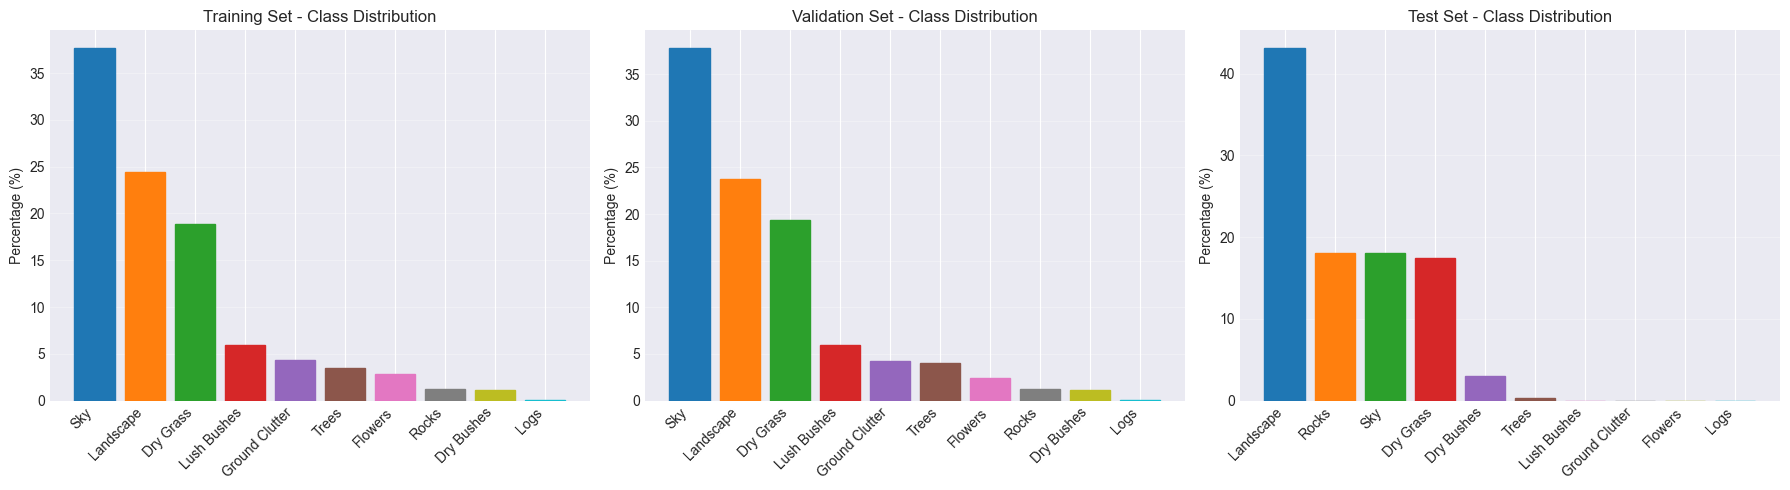


Class distribution visualization saved as 'class_distribution.png'


In [4]:
# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, df, title in zip(axes, [train_distribution, val_distribution, test_distribution], 
                          ['Training', 'Validation', 'Test']):
    bars = ax.bar(range(len(df)), df['Percentage'])
    ax.set_xticks(range(len(df)))
    ax.set_xticklabels(df['Class Name'], rotation=45, ha='right')
    ax.set_ylabel('Percentage (%)')
    ax.set_title(f'{title} Set - Class Distribution')
    ax.grid(axis='y', alpha=0.3)
    
    # Color bars by class
    colors = plt.cm.tab10(np.linspace(0, 1, len(df)))
    for bar, color in zip(bars, colors):
        bar.set_color(color)

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nClass distribution visualization saved as 'class_distribution.png'")

## 4. Visualize Sample Images and Masks

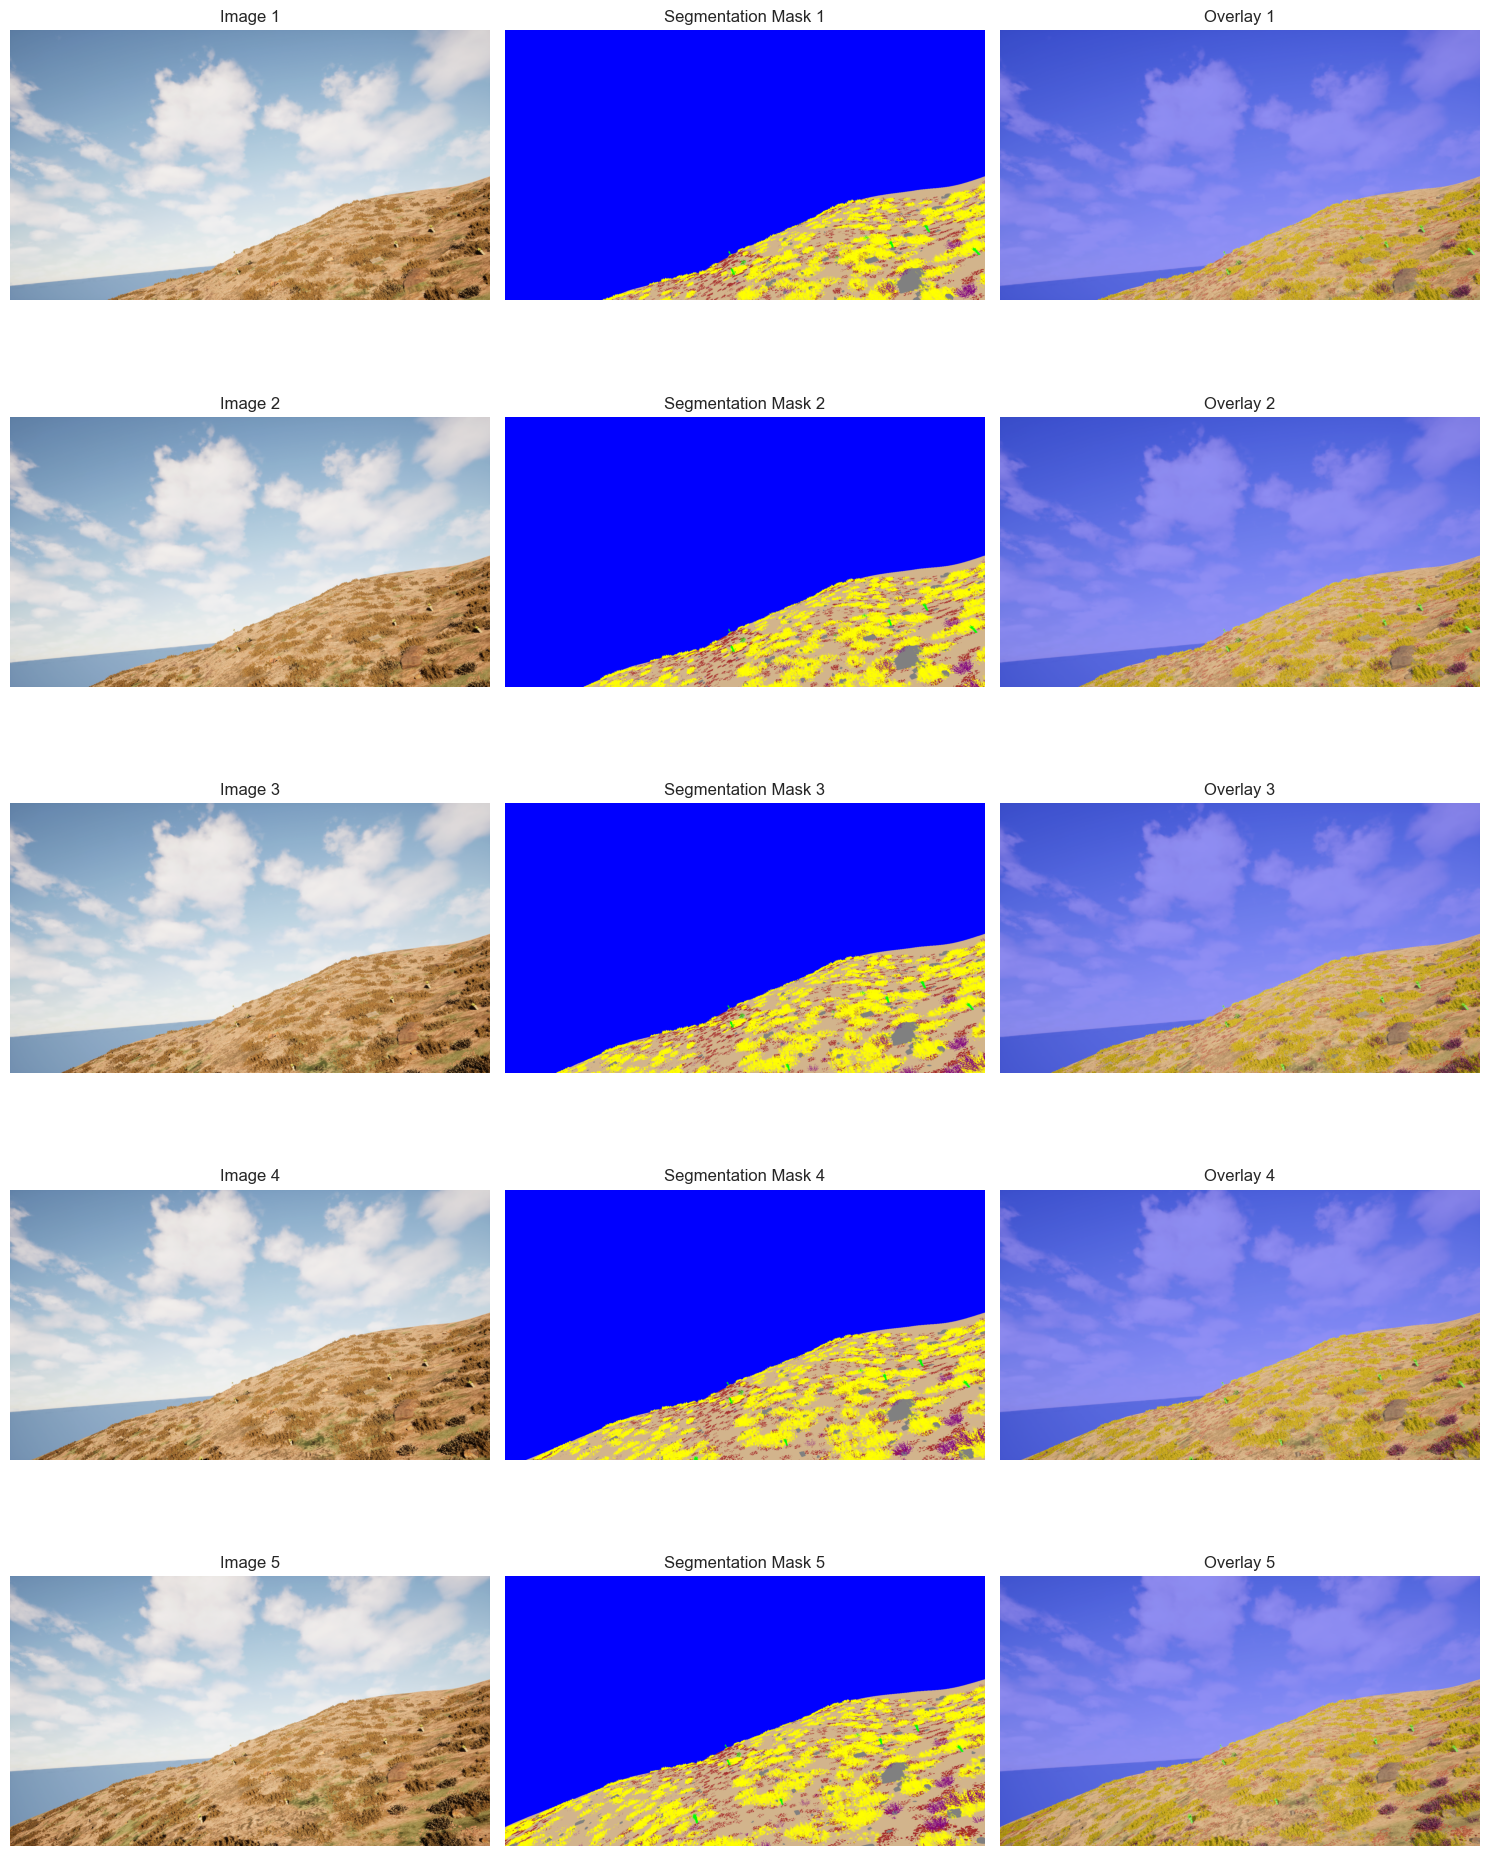

Sample visualizations saved as 'sample_visualizations.png'


In [5]:
def create_color_map():
    """Create a color map for visualization"""
    cmap = {
        100: [255, 0, 0],        # Red - Trees
        200: [0, 255, 0],        # Green - Lush Bushes
        300: [255, 255, 0],      # Yellow - Dry Grass
        500: [128, 0, 128],      # Purple - Dry Bushes
        550: [165, 42, 42],      # Brown - Ground Clutter
        600: [255, 165, 0],      # Orange - Flowers
        700: [139, 69, 19],      # Dark Brown - Logs
        800: [128, 128, 128],    # Gray - Rocks
        7100: [210, 180, 140],   # Tan - Landscape
        10000: [0, 0, 255]       # Blue - Sky
    }
    return cmap

def mask_to_rgb(mask, color_map):
    """Convert mask to RGB image using color map"""
    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    
    for class_id, color in color_map.items():
        rgb[mask == class_id] = color
    
    return rgb

color_map = create_color_map()

# Visualize samples
fig, axes = plt.subplots(5, 3, figsize=(15, 20))

for idx in range(5):
    # Load image and mask
    img = cv2.imread(os.path.join(TRAIN_IMG_PATH, train_images[idx]))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    mask = np.array(Image.open(os.path.join(TRAIN_MASK_PATH, train_masks[idx])))
    mask_rgb = mask_to_rgb(mask, color_map)
    
    # Plot
    axes[idx, 0].imshow(img_rgb)
    axes[idx, 0].set_title(f'Image {idx+1}')
    axes[idx, 0].axis('off')
    
    axes[idx, 1].imshow(mask_rgb)
    axes[idx, 1].set_title(f'Segmentation Mask {idx+1}')
    axes[idx, 1].axis('off')
    
    axes[idx, 2].imshow(cv2.addWeighted(img_rgb, 0.6, mask_rgb, 0.4, 0))
    axes[idx, 2].set_title(f'Overlay {idx+1}')
    axes[idx, 2].axis('off')

plt.tight_layout()
plt.savefig('sample_visualizations.png', dpi=300, bbox_inches='tight')
plt.show()

print("Sample visualizations saved as 'sample_visualizations.png'")

## 5. Examine Image Statistics

In [6]:
def calculate_image_statistics(img_dir, num_samples=None):
    """Calculate statistics for images"""
    images = sorted([f for f in os.listdir(img_dir) if f.endswith('.png')])
    
    if num_samples:
        images = images[:num_samples]
    
    heights, widths = [], []
    means, stds = [], []
    
    for img_file in images:
        img = cv2.imread(os.path.join(img_dir, img_file))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        heights.append(img.shape[0])
        widths.append(img.shape[1])
        
        means.append(np.mean(img_rgb / 255.0, axis=(0, 1)))
        stds.append(np.std(img_rgb / 255.0, axis=(0, 1)))
    
    means = np.array(means)
    stds = np.array(stds)
    
    print(f"\nImage Statistics (based on {len(images)} samples):")
    print(f"Height - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.2f}")
    print(f"Width - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.2f}")
    print(f"\nPixel Value Statistics (Normalized to [0, 1]):")
    print(f"Mean - R: {np.mean(means[:, 0]):.4f}, G: {np.mean(means[:, 1]):.4f}, B: {np.mean(means[:, 2]):.4f}")
    print(f"Std  - R: {np.mean(stds[:, 0]):.4f}, G: {np.mean(stds[:, 1]):.4f}, B: {np.mean(stds[:, 2]):.4f}")
    
    return {
        'heights': heights,
        'widths': widths,
        'means': means,
        'stds': stds
    }

stats = calculate_image_statistics(TRAIN_IMG_PATH, num_samples=100)


Image Statistics (based on 100 samples):
Height - Min: 1080, Max: 1080, Mean: 1080.00
Width - Min: 1920, Max: 1920, Mean: 1920.00

Pixel Value Statistics (Normalized to [0, 1]):
Mean - R: 0.5113, G: 0.4243, B: 0.3175
Std  - R: 0.3037, G: 0.2793, B: 0.2709


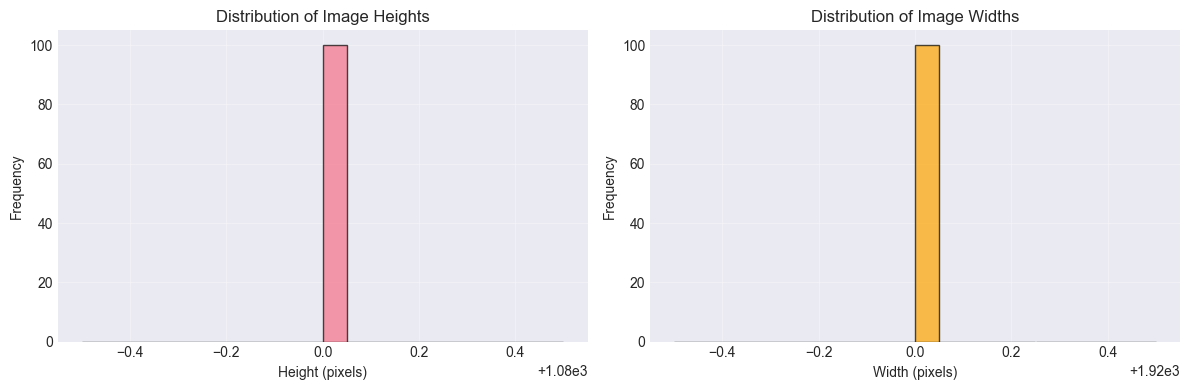

Image dimension statistics saved as 'image_dimensions.png'


In [7]:
# Visualize image dimensions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(stats['heights'], bins=20, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Height (pixels)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Image Heights')
axes[0].grid(alpha=0.3)

axes[1].hist(stats['widths'], bins=20, alpha=0.7, edgecolor='black', color='orange')
axes[1].set_xlabel('Width (pixels)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Image Widths')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('image_dimensions.png', dpi=300, bbox_inches='tight')
plt.show()

print("Image dimension statistics saved as 'image_dimensions.png'")

## 6. Data Quality Assessment

In [8]:
def assess_data_quality(img_dir, mask_dir, dataset_name):
    """Perform data quality checks"""
    print(f"\n{'='*70}")
    print(f"Data Quality Assessment - {dataset_name}")
    print(f"{'='*70}")
    
    images = sorted([f for f in os.listdir(img_dir) if f.endswith('.png')])
    masks = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])
    
    # Check if counts match
    print(f"Total images: {len(images)}")
    print(f"Total masks: {len(masks)}")
    print(f"Match: {len(images) == len(masks)}")
    
    # Check for missing masks
    missing_count = 0
    invalid_masks = 0
    
    for img_file in images[:50]:  # Check first 50
        base_name = img_file
        mask_file = os.path.join(mask_dir, base_name)
        
        if not os.path.exists(mask_file):
            missing_count += 1
        else:
            # Check mask validity
            try:
                mask = np.array(Image.open(mask_file))
                unique_vals = np.unique(mask)
                valid_classes = set(CLASS_MAPPING.keys())
                invalid_vals = set(unique_vals) - valid_classes
                if invalid_vals:
                    invalid_masks += 1
            except:
                invalid_masks += 1
    
    print(f"\nQuality Checks (sample of 50):")
    print(f"Missing masks: {missing_count}")
    print(f"Invalid masks: {invalid_masks}")
    print(f"Valid samples: {50 - missing_count - invalid_masks}")

# Assess quality for all datasets
assess_data_quality(TRAIN_IMG_PATH, TRAIN_MASK_PATH, 'TRAINING')
assess_data_quality(VAL_IMG_PATH, VAL_MASK_PATH, 'VALIDATION')
assess_data_quality(TEST_IMG_PATH, TEST_MASK_PATH, 'TEST')


Data Quality Assessment - TRAINING
Total images: 2857
Total masks: 2857
Match: True

Quality Checks (sample of 50):
Missing masks: 0
Invalid masks: 0
Valid samples: 50

Data Quality Assessment - VALIDATION
Total images: 317
Total masks: 317
Match: True

Quality Checks (sample of 50):
Missing masks: 0
Invalid masks: 0
Valid samples: 50

Data Quality Assessment - TEST
Total images: 1002
Total masks: 1002
Match: True

Quality Checks (sample of 50):
Missing masks: 0
Invalid masks: 0
Valid samples: 50


## 7. Summary and Key Findings

In [9]:
print("\n" + "="*70)
print("EDA SUMMARY")
print("="*70)

print("\n1. DATASET COMPOSITION:")
print(f"   - Training samples: {len(train_images)}")
print(f"   - Validation samples: {len(val_images)}")
print(f"   - Test samples: {len(test_images)}")
print(f"   - Total: {len(train_images) + len(val_images) + len(test_images)}")

print("\n2. CLASS IMBALANCE:")
print("   Top 3 classes in training set:")
for idx, row in train_distribution.head(3).iterrows():
    print(f"   - {row['Class Name']}: {row['Percentage']:.2f}%")
print("   Bottom 3 classes in training set:")
for idx, row in train_distribution.tail(3).iterrows():
    print(f"   - {row['Class Name']}: {row['Percentage']:.2f}%")

print("\n3. IMAGE PROPERTIES:")
print(f"   - Image dimensions: Uniform across dataset")
print(f"   - Height: {int(np.mean(stats['heights']))} pixels")
print(f"   - Width: {int(np.mean(stats['widths']))} pixels")

print("\n4. NEXT STEPS:")
print("   - Apply weighted loss function due to class imbalance")
print("   - Implement data augmentation to increase sample diversity")
print("   - Normalize images using calculated mean and std")
print("   - Consider class-specific focal loss for minority classes")
print("   - Proceed to feature engineering notebook")


EDA SUMMARY

1. DATASET COMPOSITION:
   - Training samples: 2857
   - Validation samples: 317
   - Test samples: 1002
   - Total: 4176

2. CLASS IMBALANCE:
   Top 3 classes in training set:
   - Sky: 37.68%
   - Landscape: 24.43%
   - Dry Grass: 18.85%
   Bottom 3 classes in training set:
   - Rocks: 1.20%
   - Dry Bushes: 1.10%
   - Logs: 0.08%

3. IMAGE PROPERTIES:
   - Image dimensions: Uniform across dataset
   - Height: 1080 pixels
   - Width: 1920 pixels

4. NEXT STEPS:
   - Apply weighted loss function due to class imbalance
   - Implement data augmentation to increase sample diversity
   - Normalize images using calculated mean and std
   - Consider class-specific focal loss for minority classes
   - Proceed to feature engineering notebook
